# Thijs Text Classification Test
Trying to classify the age of an author based on a written blogpost

## 1. Import libraries

In [ ]:
!pip install torchtext==0.4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import os
import time

import torch
import torchtext
from torchtext.datasets import text_classification
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import nltk
import plotly.express as px
from nltk.stem import WordNetLemmatizer
import plotly.graph_objs as go
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict, OrderedDict, Counter
import operator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load and preprocces the dataframe

In [ ]:
path = '/content/drive/MyDrive/Language, speech and dialogue processing/blogtext_full.xlsx'

In [ ]:
dataset = pd.read_excel(path)
df = pd.DataFrame(dataset)
df = df.drop(['id', 'topic', 'sign', 'date', 'gender'], axis=1)

df = df.sample(300000)
ages = df["age"].unique().tolist()
print(ages)


[25, 27, 34, 37, 23, 26, 36, 13, 16, 17, 24, 33, 46, 48, 14, 15, 45, 38, 40, 35, 39, 47, 42, 43, 41, 44]


In [ ]:
ages.sort()
age_dict = {}
for age in ages:
  age_dict[age] = df.loc[df['age'] == age]

for key, value in age_dict.items():
  age_dict[key] = value.sample(900, replace=True)
  
print(age_dict)


{13:         age                                               text
61675    13  Television commercials have become so fashiona...
204898   13          Holy Crap, we really are rednecks.   I...
151624   13                   Read some of the comments i m...
213881   13  Im not very happy as you can well see, as i do...
165393   13          urlLink    i dont know wat to write, s...
...     ...                                                ...
457462   13  Well, well, well another Oscars show. Not too ...
55525    13  lolx... todae wake up 6:50am. then go to schoo...
305960   13  thats cool, nothing interesting on this part o...
201807   13  Ok so for grade 8 Team A, there is a Social St...
300920   13         well, I was bored again so I had anothe...

[900 rows x 2 columns], 14:         age                                               text
235785   14  Your random history lesson of the day.  (Becau...
342255   14  Sanaz Joon Alan Ke In post ro Publish mikonam ...
3873     14          

In [ ]:
# Same range as in pan13 dataset

dataframes_10s = []
dataframes_20s = []
dataframes_30s = []
dataframes_40s = []

for key, value in age_dict.items():
  if 13 <= int(key) <= 17:
    dataframes_10s.append(value)
  elif 23 <= int(key) <= 27:
    dataframes_20s.append(value)
  elif 33 <= int(key) <= 37:
    dataframes_30s.append(value)
  elif 43 <= int(key) <= 47:
    dataframes_40s.append(value)

df_10s = pd.concat(dataframes_10s)
df_20s = pd.concat(dataframes_20s)
df_30s = pd.concat(dataframes_30s)
df_40s = pd.concat(dataframes_40s)

df_10s["age"] = "10s"
df_20s["age"] = "20s"
df_30s["age"] = "30s"
df_40s["age"] = "40s"

all_dataframes = [df_10s, df_20s, df_30s, df_40s]

min_len = len(all_dataframes[0])

for df in all_dataframes:
  if len(df) < min_len:
    min_len = len(df)



all_dataframes = [df_10s.sample(min_len), df_20s.sample(min_len), df_30s.sample(min_len), df_40s.sample(min_len)]

df = pd.concat(all_dataframes)



In [ ]:
df

,age,text
495484,10s,"I've not been blogging for days, so please exc..."
66437,10s,Today has been all goods and bads:&nbsp; &nbs...
416573,10s,Binary is the language of computers. Binary nu...
606307,10s,I do and I think it's pretty entertaini...
186529,10s,...men are just so unbearable i have...
...,...,...
248162,40s,Master Ensure your mouth is not fill...
360767,40s,The following is the last of three articles th...
336418,40s,The weather is so crappy even...
644587,40s,"My day was uneventful, except for when my toot..."


## 3. Create n_grams from the text (Optional)

In [ ]:
# lemmatizing function
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

# remove stopwords
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text
    
def tokenize(text):
    tokens = [token for token in text.split(" ") if token != ""]
    return tokens

def lowered(s):
    return s.lower()

def remove_html_punct(text):
    # remove html tags
    if text:
        text = BeautifulSoup(text,features="html.parser").get_text()
    
        # remove punctuation
        punc = string.punctuation + "“”‘’—"
        no_punct = [words for words in text if words not in punc]
        words_wo_punct=''.join(no_punct)
        return words_wo_punct.lower()

def remove_nonalph(s):
      s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
      return s

def generate_ngrams(s, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [ ]:
# ngram = 2
# for i, text in enumerate(df['text']):
#   if type(df['text'].iloc[i]) != list:
#     lower = lowered(text)
#     non_alph = remove_nonalph(lower)
#     tokens = tokenize(non_alph)
#     no_stopwords = remove_stopwords(tokens)
#     lemma = lemmatize(no_stopwords)
#     # ngrams = generate_ngrams(lemma, ngram)
#     df['text'].iloc[i] = lemma
# print(df['text'].iloc[0])
# print(df['text'])

df["text"] = df["text"].apply(lowered).apply(remove_nonalph).apply(tokenize)


In [ ]:
df.index = range(len(df))


In [ ]:
df


,age,text
0,10s,"[i, ve, not, been, blogging, for, days, so, pl..."
1,10s,"[today, has, been, all, goods, and, bads, nbsp..."
2,10s,"[binary, is, the, language, of, computers, bin..."
3,10s,"[i, do, and, i, think, it, s, pretty, entertai..."
4,10s,"[men, are, just, so, unbearable, i, have, dram..."
...,...,...
17995,40s,"[master, ensure, your, mouth, is, not, filled,..."
17996,40s,"[the, following, is, the, last, of, three, art..."
17997,40s,"[the, weather, is, so, crappy, even, the, weat..."
17998,40s,"[my, day, was, uneventful, except, for, when, ..."


In [ ]:
# AMOUNT_OF_CATEGORIES = 5
# df = df.assign(age_group=pd.qcut(df['age'], AMOUNT_OF_CATEGORIES, labels=[i for i in range(AMOUNT_OF_CATEGORIES)]))

In [ ]:
# hist_trace = go.Histogram(x=df['age_group'])
# go.Figure(hist_trace).show()

In [ ]:
print(df)

       age                                               text
0      10s  [i, ve, not, been, blogging, for, days, so, pl...
1      10s  [today, has, been, all, goods, and, bads, nbsp...
2      10s  [binary, is, the, language, of, computers, bin...
3      10s  [i, do, and, i, think, it, s, pretty, entertai...
4      10s  [men, are, just, so, unbearable, i, have, dram...
...    ...                                                ...
17995  40s  [master, ensure, your, mouth, is, not, filled,...
17996  40s  [the, following, is, the, last, of, three, art...
17997  40s  [the, weather, is, so, crappy, even, the, weat...
17998  40s  [my, day, was, uneventful, except, for, when, ...
17999  40s  [i, had, a, revelation, this, afternoon, i, wi...

[18000 rows x 2 columns]


## 4. To GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 5. Initialising Neural Network

In [ ]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## 6. Classes preprocessing
Checking the amount of classes and mapping them each to a different unique number 

In [ ]:
class_choice = 'age'
classdict = defaultdict(int)

for row in df[class_choice]:
  classdict[row] += 1
print(sorted(classdict))

### PROBLEM: ALS IK DIT WISSEL NAAR NORMAL SORT DAN IS DE UITKOMST INEENS ANDERS???
classdict = dict(sorted(classdict.items(), key=operator.itemgetter(1), reverse=True))
#classdict = dict(sorted(classdict.items()))
print('classdict:')
print(classdict)

fig = go.Figure([go.Bar(x=('10s', '20s', '30s'), y=[classdict['10s'], classdict['20s'], classdict['30s']])])
fig.show()

['10s', '20s', '30s', '40s']
classdict:
{'10s': 4500, '20s': 4500, '30s': 4500, '40s': 4500}


In [ ]:
# class to number mapping
classlist = list(classdict.keys())
classmap = dict([(y,x) for x,y in enumerate(classlist)])
print('classmap:')
print(classmap)
print('amount of classes')
print(len(classdict))

classmap:
{'10s': 0, '20s': 1, '30s': 2, '40s': 3}
amount of classes
4


## 7. Vocabulary dictionary
Making a dict of all the words in the dataset and mapping each unique word to a unique number

In [ ]:
vocabdict = defaultdict(int)   

for row in df['text']:
  for n_gram in row:
    n_gram = n_gram.lower()
    vocabdict[n_gram] += 1

vocabdict = dict(sorted(vocabdict.items(), key=operator.itemgetter(1), reverse=True))
print(vocabdict)

{'the': 174957, 'i': 142642, 'to': 119072, 'and': 109375, 'a': 87544, 'of': 79181, 'in': 57567, 'it': 56763, 'that': 55579, 'is': 43562, 'my': 39092, 'you': 37499, 'for': 36929, 's': 36313, 'was': 33895, 'on': 30702, 't': 26905, 'me': 26469, 'with': 26412, 'but': 25670, 'have': 25670, 'this': 25579, 'he': 23784, 'so': 23379, 'we': 23245, 'be': 22883, 'not': 20827, 'at': 20321, 'as': 20314, 'are': 17929, 'all': 17643, 'they': 17157, 'nbsp': 15037, 'just': 14857, 'she': 14633, 'up': 14360, 'like': 14324, 'her': 14324, 'out': 14311, 'about': 14274, 'from': 14098, 'one': 14060, 'what': 14015, 'or': 13900, 'can': 13847, 'm': 12814, 'if': 12650, 'there': 12614, 'had': 12394, 'do': 12316, 'urllink': 11975, 'his': 11974, 'when': 11918, 'will': 11886, 'by': 11150, 'get': 10706, 'time': 10267, 'who': 9844, 'some': 9828, 'an': 9807, 'now': 9665, 'know': 9565, 'more': 9550, 'would': 9239, 'no': 9187, 'then': 9115, 'has': 9100, 'your': 9020, 'don': 8739, 'him': 8413, 'been': 8376, 'were': 8215, 'th

In [ ]:
# WORD TO NUMBER MAPPING
l = list(vocabdict.keys())
wordmap = dict([(y,x) for x,y in enumerate(l)])
print(wordmap)

{'the': 0, 'i': 1, 'to': 2, 'and': 3, 'a': 4, 'of': 5, 'in': 6, 'it': 7, 'that': 8, 'is': 9, 'my': 10, 'you': 11, 'for': 12, 's': 13, 'was': 14, 'on': 15, 't': 16, 'me': 17, 'with': 18, 'but': 19, 'have': 20, 'this': 21, 'he': 22, 'so': 23, 'we': 24, 'be': 25, 'not': 26, 'at': 27, 'as': 28, 'are': 29, 'all': 30, 'they': 31, 'nbsp': 32, 'just': 33, 'she': 34, 'up': 35, 'like': 36, 'her': 37, 'out': 38, 'about': 39, 'from': 40, 'one': 41, 'what': 42, 'or': 43, 'can': 44, 'm': 45, 'if': 46, 'there': 47, 'had': 48, 'do': 49, 'urllink': 50, 'his': 51, 'when': 52, 'will': 53, 'by': 54, 'get': 55, 'time': 56, 'who': 57, 'some': 58, 'an': 59, 'now': 60, 'know': 61, 'more': 62, 'would': 63, 'no': 64, 'then': 65, 'has': 66, 'your': 67, 'don': 68, 'him': 69, 'been': 70, 'were': 71, 'them': 72, 'am': 73, 'people': 74, 'think': 75, 'go': 76, 'really': 77, 'good': 78, 'well': 79, 'how': 80, 'their': 81, 'our': 82, 'back': 83, 'day': 84, 'got': 85, 'see': 86, 'because': 87, 'going': 88, 'which': 89, 

## 8. Mapping text column to numbers (tensor)

In [ ]:
df_copy = df.copy()

for i, text in enumerate(df['text']):
  newtext = []
  for word in text:
    word = word.lower()
    newtext.append(int(wordmap[word]))
  df['text'][i] = torch.tensor(newtext).to(torch.int64)

In [ ]:
train_dataset = []

for index, row in df.iterrows():
  clasn = classmap[row['age']]
  train_dataset.append(tuple((clasn, row['text'])))

As you can see below the train dataset is now a list with tuples (age, text)

In [ ]:
print(train_dataset[0])

(0, tensor([    1,    96,    26,    70,  1293,    12,   185,    23,   416,  1758,
           17,   545,   263,   142,    29,    30,    10, 50426,  4118,   323,
           18,    10,   383,     7,   455,    36,    41,   285,  9958,     5,
        16870,  3819,   260,    83,     2,     0,  1341,     1,   105,  1039,
         1252,   545,    79,    19,  6675,    39,   742,   214,     8,     9,
           26,    39,   198,  2410, 19540,   527,    89,     1,    73,  2166,
            5,   203,    19,     1,    96,  5594,    80,     2,  2655,  4246,
            9,    36, 14973,     0, 14148, 18127,    15,     0,  8022,     8,
           48,  5773,     7,    41,     5,    10,   554,  3179,    54,    41,
            5,    10,   554,  2385,  1130, 15805,   441,   181,  1039,  1252,
          168,    50, 50427,  3440,     6,    21,   472,   131,    50, 50428,
          181,    50,  7527, 12328,     3,  5774, 12328,    13,   107,  1039,
          212,     9,    10,   107,   219,   105,   545,    

## 9. Run neural network

In [ ]:
vocab = len(vocabdict)
embed_dim = 32
n_classes = len(classdict)
BATCH_SIZE = 16
model = TextSentiment(vocab, embed_dim, n_classes).to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/Language, speech and dialogue processing/pan_state.pth'))

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Language, speech and dialogue processing/Blog_nn_confusion_matrix.png')
    

In [ ]:
def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_, last_epoch=False):
    loss = 0
    acc = 0
    predictions = []
    labels = []
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
        pred = output.argmax(1).to('cpu')
        label = cls.to('cpu')
        predictions.extend(pred)
        labels.extend(label)
    if last_epoch == False:
      return loss / len(data_), acc / len(data_)
    else:
      return predictions, labels

Epoch: 1
	Loss: 0.0875(train)	|	Acc: 33.2%(train)
	Loss: 0.0016(valid)	|	Acc: 35.2%(valid)
Epoch: 2
	Loss: 0.0806(train)	|	Acc: 40.6%(train)
	Loss: 0.0020(valid)	|	Acc: 35.3%(valid)
Epoch: 3
	Loss: 0.0753(train)	|	Acc: 45.8%(train)
	Loss: 0.0018(valid)	|	Acc: 40.3%(valid)
Epoch: 4
	Loss: 0.0708(train)	|	Acc: 49.7%(train)
	Loss: 0.0018(valid)	|	Acc: 46.8%(valid)
Epoch: 5
	Loss: 0.0667(train)	|	Acc: 54.2%(train)
	Loss: 0.0024(valid)	|	Acc: 38.3%(valid)
Epoch: 6
	Loss: 0.0632(train)	|	Acc: 57.1%(train)
	Loss: 0.0016(valid)	|	Acc: 46.6%(valid)
Epoch: 7
	Loss: 0.0603(train)	|	Acc: 59.7%(train)
	Loss: 0.0020(valid)	|	Acc: 48.6%(valid)
Epoch: 8
	Loss: 0.0572(train)	|	Acc: 62.5%(train)
	Loss: 0.0020(valid)	|	Acc: 50.7%(valid)
Epoch: 9
	Loss: 0.0542(train)	|	Acc: 64.8%(train)
	Loss: 0.0020(valid)	|	Acc: 49.2%(valid)
Epoch: 10
	Loss: 0.0520(train)	|	Acc: 67.2%(train)
	Loss: 0.0023(valid)	|	Acc: 51.9%(valid)
Epoch: 11
	Loss: 0.0497(train)	|	Acc: 69.3%(train)
	Loss: 0.0028(valid)	|	Acc: 48.8%(vali

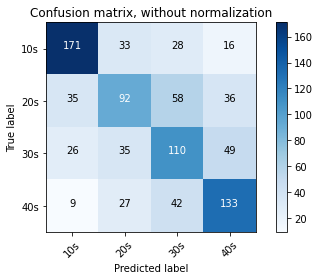

In [ ]:
N_EPOCHS = 50
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
#train_len = int(len(train_dataset) * 0.50)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

start_time = time.time()
for epoch in range(N_EPOCHS):

    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    print('Epoch: %d' %(epoch + 1))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')
    if epoch == (N_EPOCHS-1):
      predictions, labels = test(sub_valid_, True)
      conf_matrix = confusion_matrix(np.array(labels), np.array(predictions), labels=[0, 1, 2, 3])
      np.set_printoptions(precision=2)
      # Plot non-normalized confusion matrix
      #plt.figure()
      plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s', '40s'], title='Confusion matrix, without normalization')

total_time = int(time.time() - start_time)
print('Total time elapsed: %d seconds.' %(total_time))

Normalized confusion matrix
[[0.69 0.13 0.11 0.06]
 [0.16 0.42 0.26 0.16]
 [0.12 0.16 0.5  0.22]
 [0.04 0.13 0.2  0.63]]


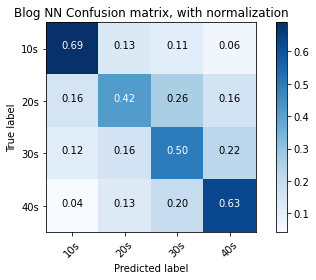

In [ ]:
plot_confusion_matrix(conf_matrix, classes=['10s', '20s', '30s', '40s'], normalize=True, title='Blog NN Confusion matrix, with normalization')

In [ ]:
def predict(text, model, wordmap):
    sentence = []
    for word in text:
      word = word.lower()
      sentence.append(int(wordmap[word]))
    text = torch.tensor(sentence).to(torch.int64)

    with torch.no_grad():
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()



test_text = df_copy['text'][100]

model = model.to("cpu")

inv_map = {v: k for k, v in classmap.items()}
print(inv_map)
print(predict(test_text,model,wordmap))
print("I predict the author of this article is in his/her %a." %inv_map[predict(test_text, model, wordmap)])

{0: '10s', 1: '20s', 2: '30s', 3: '40s'}
0
I predict the author of this article is in his/her '10s'.


<function matplotlib.pyplot.plot>

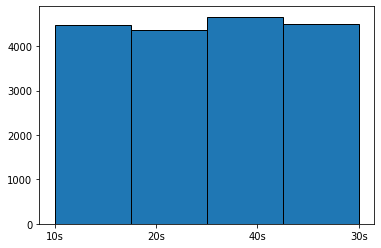

In [ ]:
pred_dis = [inv_map[predict(x, model, wordmap)] for x in df_copy['text']]
pred_dict = Counter(pred_dis)

import matplotlib.pyplot as plt
plt.hist(pred_dis, len(pred_dict), edgecolor='black')
plt.plot
